In [1]:
# Load autoreload extension
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
from datasets import load_dataset

from classifier import *

/home/emmadann/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load clinical success annotation

In [3]:
# Load drug metadata from huggingface
ds = load_dataset("tahoebio/Tahoe-100M", "drug_metadata")
drug_metadata = ds["train"].to_pandas()
drug_metadata['pubchem_cid_str'] = drug_metadata['pubchem_cid'].astype(str)
drug_metadata['pubchem_cid_str'] = drug_metadata['pubchem_cid_str'].str.split('\\.0').str[0]

cs = load_dataset("tahoebio/Tahoe-100M", "cell_line_metadata")
cell_line_metadata = cs["train"].to_pandas()
cell_line_metadata.head()

# Create a mapping from cell line ID to organ
cell_line_to_organ = dict(zip(cell_line_metadata['Cell_ID_Cellosaur'], cell_line_metadata['Organ']))

# Create a list of all drug names vs all cell line names (Cell_ID_Cellosaur)
# First, get unique drug names and cell line IDs
unique_drugs = drug_metadata['drug'].unique()
unique_cell_lines = cell_line_metadata['Cell_ID_Cellosaur'].unique()

# Create a DataFrame with all combinations of drugs and cell lines
drug_cellline_combinations = []
for drug in unique_drugs:
    for cell_line in unique_cell_lines:
        drug_cellline_combinations.append({
            'drug': drug,
            'cell_line': cell_line,
            'drug-cell_line': f"{drug}_{cell_line}"
        })

# Convert to DataFrame
drug_cellline_df = pd.DataFrame(drug_cellline_combinations)

# Display the first few rows
print(f"Total combinations: {len(drug_cellline_df)}")
drug_cellline_df.head()
# Add organ information to the drug_cellline_df
drug_cellline_df['organ'] = drug_cellline_df['cell_line'].map(cell_line_to_organ)

# Create a drug_organ column by combining drug name and organ
drug_cellline_df['drug_organ'] = drug_cellline_df['drug'] + '_' + drug_cellline_df['organ']

drug_cellline_df


Total combinations: 38658


,drug,cell_line,drug-cell_line,organ,drug_organ
0,Talc,CVCL_0023,Talc_CVCL_0023,Lung,Talc_Lung
1,Talc,CVCL_1286,Talc_CVCL_1286,Lung,Talc_Lung
2,Talc,CVCL_1282,Talc_CVCL_1282,Vulva/Vagina,Talc_Vulva/Vagina
3,Talc,CVCL_1034,Talc_CVCL_1034,Skin,Talc_Skin
4,Talc,CVCL_2610,Talc_CVCL_2610,Skin,Talc_Skin
...,...,...,...,...,...
38653,γ-Oryzanol,CVCL_1547,γ-Oryzanol_CVCL_1547,Lung,γ-Oryzanol_Lung
38654,γ-Oryzanol,CVCL_1495,γ-Oryzanol_CVCL_1495,Lung,γ-Oryzanol_Lung
38655,γ-Oryzanol,CVCL_1531,γ-Oryzanol_CVCL_1531,Lung,γ-Oryzanol_Lung
38656,γ-Oryzanol,CVCL_1517,γ-Oryzanol_CVCL_1517,Lung,γ-Oryzanol_Lung


In [4]:
# Read approval tables
approved_df = pd.read_csv('data/drugs_organs_approved.csv', index_col=0)
tested_df = pd.read_csv('data/drugs_organs_tested.csv', index_col=0)

# Map from pubchem_id to drug name
pubchem_to_drug = dict(zip(drug_metadata['pubchem_cid_str'].astype(str), drug_metadata['drug']))
tested_df.index = tested_df.index.map(lambda x: pubchem_to_drug.get(str(x), f"Unknown-{x}"))
approved_df.index = approved_df.index.map(lambda x: pubchem_to_drug.get(str(x), f"Unknown-{x}"))

# Melt the dataframes to have drug column and organ column
long_approved_df = approved_df.melt(var_name='organ', value_name='is_approved', ignore_index=False).reset_index().rename({'pubchem_id':'drug'}, axis=1)
long_approved_df['drug_organ'] = long_approved_df['drug'] + '_' + long_approved_df['organ']

long_tested_df = tested_df.melt(var_name='organ', value_name='is_tested', ignore_index=False).reset_index().rename({'pubchem_id':'drug'}, axis=1)
long_tested_df['drug_organ'] = long_tested_df['drug'] + '_' + long_tested_df['organ']

# Filter to only tested combos
long_approved_df = long_approved_df[long_tested_df['is_tested'] == 1]

In [5]:
# adata_ldvae = sc.read_h5ad('ldvae_cellline_drug_aggr.h5ad')
# # Split the drugname_drugconc column into three separate columns
# drug_info = adata_ldvae.obs['drugname_drugconc'].str.strip('[]').str.extract(r'\(\'(.*?)\', (.*?), \'(.*?)\'\)')
# adata_ldvae.obs['drug_name'] = drug_info[0].str.strip()
# adata_ldvae.obs['drug_concentration'] = drug_info[1].astype(float)

# adata_ldvae.obs['organ'] = adata_ldvae.obs['cell_line'].map(cell_line_to_organ)
# adata_ldvae = adata_ldvae[adata_ldvae.obs['drug_concentration'] == 5]
# adata_ldvae.obs['drug_organ'] = adata_ldvae.obs['drug_name'] + '_' + adata_ldvae.obs['organ']

In [6]:
# common_drug_organ = np.intersect1d(adata_ldvae.obs['drug_organ'].unique(), long_approved_df['drug_organ'].unique())

# adata_ldvae_subset = adata_ldvae[adata_ldvae.obs['drug_organ'].isin(common_drug_organ)]

# X = adata_ldvae_subset.layers['mean_LDVAE_embedding'].copy()
# drug_organ_vec = adata_ldvae_subset.obs['drug_organ']
# y = long_approved_df.set_index('drug_organ').loc[drug_organ_vec]['is_approved']

# # Convert indices to drug-cell_line
# assert len(y) == X.shape[0]
# X = pd.DataFrame(X)
# adata_ldvae_subset.obs['drug-cell_line'] = adata_ldvae_subset.obs['drug_name'].astype(str) + '_' + adata_ldvae.obs['cell_line'].astype(str)
# y.index = adata_ldvae_subset.obs['drug-cell_line'].values
# X.index = adata_ldvae_subset.obs['drug-cell_line'].values


In [7]:
# drug_name = X.index.str.split('_CVCL_').str[0]
# cell_line_name = 'CVCL_' + X.index.str.split('_CVCL_').str[1]


## Load features

In [111]:
# E-distance
edist = pd.read_csv('./data/tahoe_largest_edist_per_drug_cell_line_combo.csv')
edist['cell_line'] = cell_line_metadata[['cell_name','Cell_ID_Cellosaur']].drop_duplicates().set_index('cell_name').loc[edist['cell_line']].Cell_ID_Cellosaur.values
edist['drug-cell_line'] = edist['drug_name'].astype(str) + '_' + edist['cell_line'].astype(str)
edist_df = edist.set_index('drug-cell_line')[['max_e_distance']]
edist_df = edist_df[edist_df.index.isin(drug_cellline_df['drug-cell_line'])]
edist_df['drug_organ'] = drug_cellline_df.set_index('drug-cell_line').loc[edist_df.index]['drug_organ']

edist_df.to_csv('./data_for_classifier/max_edist.csv')
edist_df.head()

,max_e_distance,drug_organ
drug-cell_line,,
Homoharringtonine_CVCL_1097,77.017775,Homoharringtonine_Skin
Homoharringtonine_CVCL_0218,77.017775,Homoharringtonine_Bowel
Harringtonine_CVCL_1478,70.707085,Harringtonine_Lung
Homoharringtonine_CVCL_0366,77.017775,Homoharringtonine_Liver
Homoharringtonine_CVCL_1285,77.017775,Homoharringtonine_Lung


In [112]:
# mrVI
mrvi_emb = pd.read_csv('./data_for_classifier/tahoe_pseudobulk_z-space_by_sample.csv', index_col=0)
mrvi_emb['cell_line'] = mrvi_emb.index.str.split('_').str[0]
mrvi_emb['drug_name'] = mrvi_emb.index.str.split('_').str[1]
mrvi_emb['cell_line'] = cell_line_metadata[['cell_name','Cell_ID_Cellosaur']].drop_duplicates().set_index('cell_name').loc[mrvi_emb['cell_line']].Cell_ID_Cellosaur.values
mrvi_emb['drug-cell_line'] = mrvi_emb['drug_name'].astype(str) + '_' + mrvi_emb['cell_line'].astype(str)
mrvi_emb.index = mrvi_emb['drug-cell_line']
mrvi_emb = mrvi_emb[mrvi_emb.index.isin(drug_cellline_df['drug-cell_line'])]
mrvi_emb = mrvi_emb.drop(['drug-cell_line', 'drug_name', 'cell_line'], axis=1)
mrvi_emb['drug_organ'] = drug_cellline_df.set_index('drug-cell_line').loc[mrvi_emb.index]['drug_organ']
mrvi_emb.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X22,X23,X24,X25,X26,X27,X28,X29,X30,drug_organ
drug-cell_line,,,,,,,,,,,,,,,,,,,,,
8-Hydroxyquinoline_CVCL_0023,-0.213787,0.565904,0.039704,0.403183,0.263457,-0.183731,-0.652466,-1.022551,0.408729,0.048305,...,-0.116504,1.252591,-0.581706,-1.117497,0.883995,-0.040421,0.310658,0.060963,0.475998,8-Hydroxyquinoline_Lung
8-Hydroxyquinoline_CVCL_0332,0.779318,0.704898,0.272889,-0.981048,0.449288,0.413061,-0.458381,-0.319680,0.684116,0.506082,...,-0.262083,-0.396212,0.381725,-0.824410,-0.419530,1.691034,-0.122392,1.816938,-0.661881,8-Hydroxyquinoline_Breast
8-Hydroxyquinoline_CVCL_0292,-0.771231,0.316762,-1.287454,0.419516,0.707284,0.165528,-0.092563,-0.619698,-0.166979,0.780601,...,-0.035934,0.919477,-0.265929,0.193840,-0.185440,-0.482807,0.066068,0.537396,0.108773,8-Hydroxyquinoline_Bowel
8-Hydroxyquinoline_CVCL_1285,-0.544560,-0.235235,-0.499555,-0.189770,0.674474,0.084030,-0.412386,-0.761185,0.634883,0.087151,...,-0.104640,-0.154316,0.988890,-0.315711,-0.284397,0.518847,0.070113,1.295002,0.184966,8-Hydroxyquinoline_Lung
8-Hydroxyquinoline_CVCL_0069,-0.292731,0.016341,-1.273121,-0.077609,-0.885130,0.880758,1.940214,-0.715786,1.861963,0.318029,...,-1.425164,0.225483,1.789956,-0.335696,-1.148991,0.124015,1.663318,0.200804,-0.067681,8-Hydroxyquinoline_Skin


## Prep datasets

In [91]:
# input_features = edist_df
# outcomes = long_approved_df[['is_approved', 'drug_organ']]

# common_drug_organ = np.intersect1d(input_features['drug_organ'].unique(), outcomes['drug_organ'].unique())

# input_features = input_features[input_features['drug_organ'].isin(common_drug_organ)]

# drug_organ_vec = input_features['drug_organ']
# outcomes = outcomes.set_index('drug_organ').loc[drug_organ_vec]
# outcomes.index = input_features.index

# # Convert indices to drug-cell_line
# # assert len(y) == X.shape[0]
# X = input_features.drop('drug_organ', axis=1)
# y = outcomes.copy()

In [113]:
from classifier import *

## Test associations

In [115]:
test_features = {
    'E-dist':edist_df,
    'mrVI':mrvi_emb
}

In [99]:
mrvi_emb = pd.read_csv('./data_for_classifier/tahoe_pseudobulk_z-space_by_sample.csv', index_col=0)
mrvi_emb['cell_line'] = mrvi_emb.index.str.split('_').str[0]
mrvi_emb['drug_name'] = mrvi_emb.index.str.split('_').str[1]
mrvi_emb['cell_line'] = cell_line_metadata[['cell_name','Cell_ID_Cellosaur']].drop_duplicates().set_index('cell_name').loc[mrvi_emb['cell_line']].Cell_ID_Cellosaur.values
mrvi_emb['drug-cell_line'] = mrvi_emb['drug_name'].astype(str) + '_' + mrvi_emb['cell_line'].astype(str)
mrvi_emb.index = mrvi_emb['drug-cell_line']
mrvi_emb = mrvi_emb[mrvi_emb.index.isin(drug_cellline_df['drug-cell_line'])]
mrvi_emb = mrvi_emb.drop(['drug-cell_line', 'drug_name', 'cell_line'], axis=1)
mrvi_emb['drug_organ'] = drug_cellline_df.set_index('drug-cell_line').loc[mrvi_emb.index]['drug_organ']
mrvi_emb.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X22,X23,X24,X25,X26,X27,X28,X29,X30,drug_organ
drug-cell_line,,,,,,,,,,,,,,,,,,,,,
8-Hydroxyquinoline_CVCL_0023,-0.213787,0.565904,0.039704,0.403183,0.263457,-0.183731,-0.652466,-1.022551,0.408729,0.048305,...,-0.116504,1.252591,-0.581706,-1.117497,0.883995,-0.040421,0.310658,0.060963,0.475998,8-Hydroxyquinoline_Lung
8-Hydroxyquinoline_CVCL_0332,0.779318,0.704898,0.272889,-0.981048,0.449288,0.413061,-0.458381,-0.319680,0.684116,0.506082,...,-0.262083,-0.396212,0.381725,-0.824410,-0.419530,1.691034,-0.122392,1.816938,-0.661881,8-Hydroxyquinoline_Breast
8-Hydroxyquinoline_CVCL_0292,-0.771231,0.316762,-1.287454,0.419516,0.707284,0.165528,-0.092563,-0.619698,-0.166979,0.780601,...,-0.035934,0.919477,-0.265929,0.193840,-0.185440,-0.482807,0.066068,0.537396,0.108773,8-Hydroxyquinoline_Bowel
8-Hydroxyquinoline_CVCL_1285,-0.544560,-0.235235,-0.499555,-0.189770,0.674474,0.084030,-0.412386,-0.761185,0.634883,0.087151,...,-0.104640,-0.154316,0.988890,-0.315711,-0.284397,0.518847,0.070113,1.295002,0.184966,8-Hydroxyquinoline_Lung
8-Hydroxyquinoline_CVCL_0069,-0.292731,0.016341,-1.273121,-0.077609,-0.885130,0.880758,1.940214,-0.715786,1.861963,0.318029,...,-1.425164,0.225483,1.789956,-0.335696,-1.148991,0.124015,1.663318,0.200804,-0.067681,8-Hydroxyquinoline_Skin


In [110]:
for input_features in 
    outcomes = long_approved_df[['is_approved', 'drug_organ']]

    common_drug_organ = np.intersect1d(input_features['drug_organ'].unique(), outcomes['drug_organ'].unique())

    input_features = input_features[input_features['drug_organ'].isin(common_drug_organ)]

    drug_organ_vec = input_features['drug_organ']
    outcomes = outcomes.set_index('drug_organ').loc[drug_organ_vec]
    outcomes.index = input_features.index

    # Convert indices to drug-cell_line
    assert outcomes.shape[0] == input_features.shape[0]
    X = input_features.drop('drug_organ', axis=1)
    y = outcomes.copy()

    # Initialize a results dataframe to store metrics for each split
    results_df = pd.DataFrame(columns=['split_seed', 'pr_auc', 'accuracy', 'pr_auc_baseline', 'n_samples'])

    for s in [432, 43, 5235, 332,2132]:
        X_train, X_test, y_train, y_test = prepare_data(X, y, split_seed=s)    
        lr_model = train_linear_model(X_train, y_train, alpha=0.001)    

        lr_pred, lr_prob, pr_auc, pr_auc_baseline = evaluate_model(lr_model, X_test, y_test)    
        coef_df = analyze_coefficients(lr_model, X_train.columns)
        
        # Calculate accuracy for this split
        accuracy = sum(lr_pred == y_test['is_approved']) / len(y_test)
        
        # Store results in the dataframe
        new_row = pd.DataFrame({
            'split_seed': [s],
            'pr_auc': [pr_auc],
            'accuracy': [accuracy],
            'pr_auc_baseline':[pr_auc_baseline],
            'n_samples': [len(y_test)]
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)

    # Display the results
    print("Results across different splits:")
    print(results_df)

    results_df['X_features'] = 'mrvi'
    all_results_df = pd.concat([all_results_df, results_df])

SyntaxError: invalid syntax (3996308086.py, line 1)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5116358497397835
            Iterations: 115
            Function evaluations: 115
            Gradient evaluations: 115
Model training Precision-Recall AUC: 0.2901
Model training ROC AUC: 0.5875
Regularization: alpha=0.001

ROC AUC: 0.5486
Baseline ROC AUC: 0.5000
PR AUC: 0.3136
Baseline PR AUC: 0.2910


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 27 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
    Feature  Coefficient   p_value  Odds_Ratio  CI_Lower_95  CI_Upper_95
X7       X7     0.592554  0.000006    1.808602     0.335135     0.849973
X17     X17     0.449705  0.000473    1.567849     0.197574     0.701835
X18     X18     0.399090  0.002788    1.490468     0.137503     0.660677
X28     X28     0.379425  0.018576    1.461444     0.063503     0.695347
X26     X26     0.330700  0.016287    1.391942     0.060906     0.600495
X27     X27     0.310941  0.047337    1.364708     0.003655     0.618226
X3       X3    -0.307763  0.018995    0.735090    -0.564925    -0.050601
X11     X11     0.307033  0.003232    1.359386     0.102678     0.511388
X12     X12     0.256723  0.049120    1.292687     0.000990     0.512457
X30     X30     0.243703  0.004647    1.275965     0.074956     0.412450

Number of significant coefficients (p < 0.05): 10 out of 30


/tmp/ipykernel_2635361/3892663748.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6140979290516404
            Iterations: 102
            Function evaluations: 102
            Gradient evaluations: 102
Model training Precision-Recall AUC: 0.5319
Model training ROC AUC: 0.6793
Regularization: alpha=0.001

ROC AUC: 0.5565
Baseline ROC AUC: 0.5000
PR AUC: 0.2833
Baseline PR AUC: 0.2532

Top significant features (p < 0.05):
    Feature  Coefficient       p_value  Odds_Ratio  CI_Lower_95  CI_Upper_95
X26     X26     0.658992  1.738886e-09    1.932844     0.444458     0.873527
X18     X18     0.487143  1.039531e-06    1.627659     0.291651     0.682635
X4       X4     0.452856  9.244590e-04    1.572798     0.184912     0.720800
X14     X14    -0.452321  1.293728e-04    0.636150    -0.683933    -0.220708
X5       X5    -0.362852  1.076458e-05    0.695689    -0.524439    -0.201266
X12     X12     0.327092  5.748314e-04    1.386929     0.140903     0.513281
X7       X7     0.313691  

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 27 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5721489287071105
            Iterations: 114
            Function evaluations: 115
            Gradient evaluations: 114
Model training Precision-Recall AUC: 0.3808
Model training ROC AUC: 0.6413
Regularization: alpha=0.001

ROC AUC: 0.5648
Baseline ROC AUC: 0.5000
PR AUC: 0.3082
Baseline PR AUC: 0.2751

Top significant features (p < 0.05):
    Feature  Coefficient       p_value  Odds_Ratio  CI_Lower_95  CI_Upper_95
X4       X4     0.967347  5.760063e-09    2.630955     0.641780     1.292914
X8       X8    -0.703683  1.491064e-03    0.494760    -1.137880    -0.269485
X27     X27     0.630055  7.908037e-06    1.877714     0.353650     0.906460
X7       X7     0.497363  1.861295e-04    1.644379     0.236518     0.758208
X26     X26     0.432066  5.137945e-04    1.540437     0.188265     0.675868
X28     X28     0.426826  4.885022e-03    1.532386     0.129595     0.724057
X21     X21    -0.352898  

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 20 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5358567271931806
            Iterations: 102
            Function evaluations: 103
            Gradient evaluations: 102
Model training Precision-Recall AUC: 0.2912
Model training ROC AUC: 0.5972
Regularization: alpha=0.001

ROC AUC: 0.5763
Baseline ROC AUC: 0.5000
PR AUC: 0.3432
Baseline PR AUC: 0.2886

Top significant features (p < 0.05):
    Feature  Coefficient   p_value  Odds_Ratio  CI_Lower_95  CI_Upper_95
X26     X26     0.469618  0.000200    1.599382     0.222096     0.717140
X7       X7     0.350863  0.004048    1.420293     0.111621     0.590105
X12     X12     0.345807  0.000971    1.413130     0.140354     0.551260
X3       X3    -0.233851  0.047574    0.791479    -0.465202    -0.002501
X11     X11     0.198632  0.023006    1.219733     0.027381     0.369884

Number of significant coefficients (p < 0.05): 5 out of 30


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 20 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5532086280837092
            Iterations: 113
            Function evaluations: 114
            Gradient evaluations: 113
Model training Precision-Recall AUC: 0.3251
Model training ROC AUC: 0.6094
Regularization: alpha=0.001

ROC AUC: 0.5538
Baseline ROC AUC: 0.5000
PR AUC: 0.3062
Baseline PR AUC: 0.2829

Top significant features (p < 0.05):
    Feature  Coefficient       p_value  Odds_Ratio  CI_Lower_95  CI_Upper_95
X7       X7     0.635272  1.834550e-08    1.887535     0.413994     0.856549
X26     X26     0.473576  1.583249e-05    1.605727     0.258557     0.688596
X27     X27     0.456759  2.690926e-04    1.578948     0.211044     0.702474
X4       X4     0.435454  2.442825e-03    1.545665     0.153811     0.717097
X8       X8    -0.412477  2.981535e-02    0.662008    -0.784596    -0.040359
X10     X10     0.360876  1.649655e-04    1.434586     0.173132     0.548620
X18     X18     0.352201  

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 24 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Results across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.313602  0.709015         0.290985     14609
1         43  0.283308  0.637536         0.253224     14189
2       5235  0.308247  0.723569         0.275057     14557
3        332  0.343217  0.711430         0.288570     14156
4       2132  0.306243  0.717066         0.282934     13975


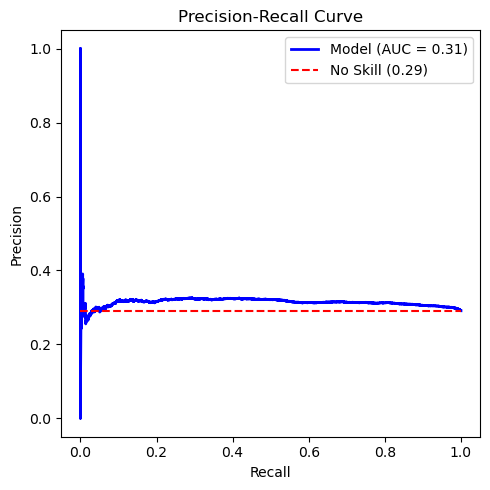

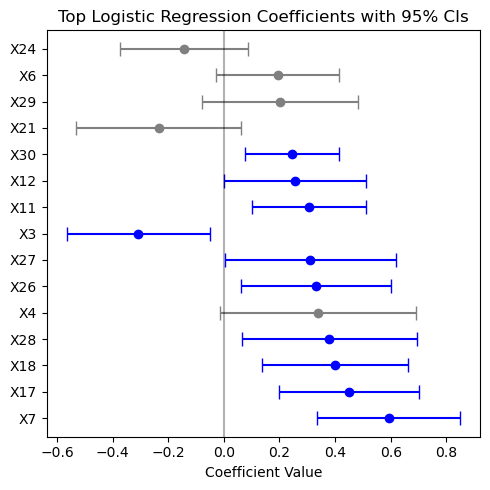

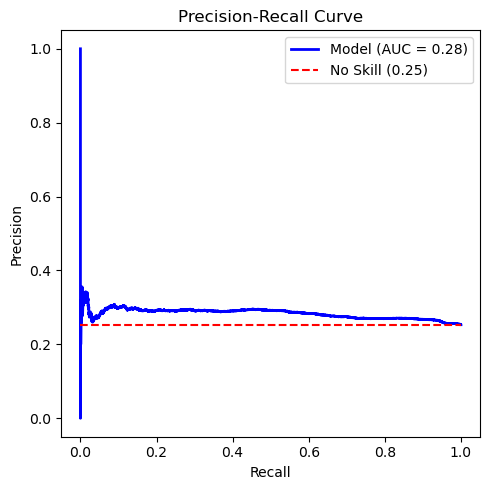

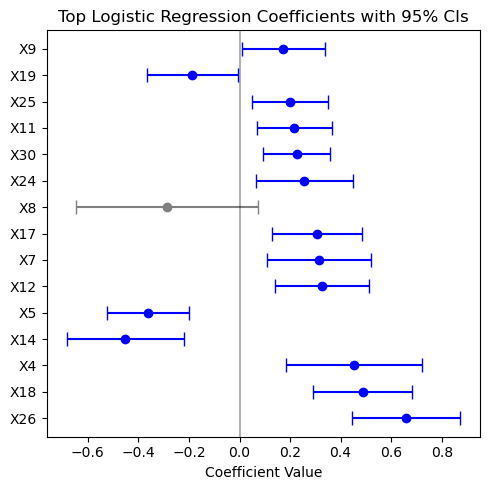

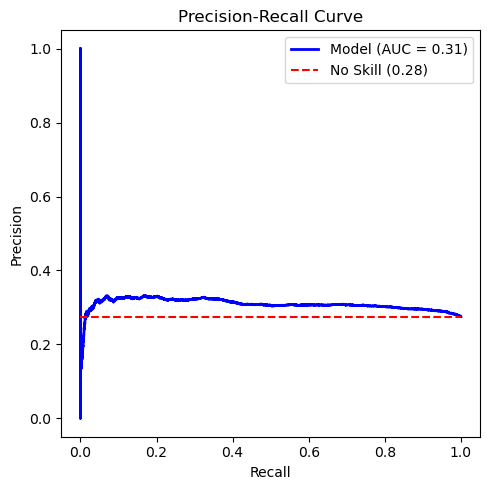

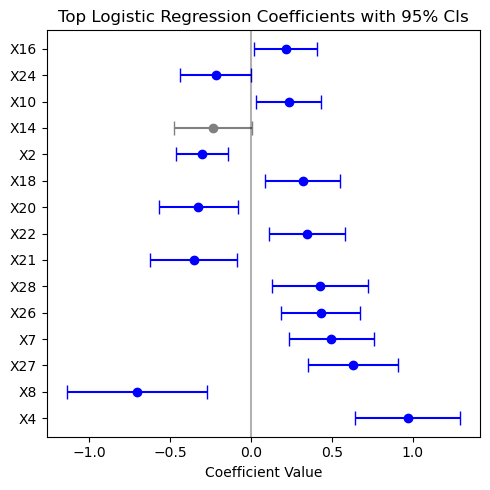

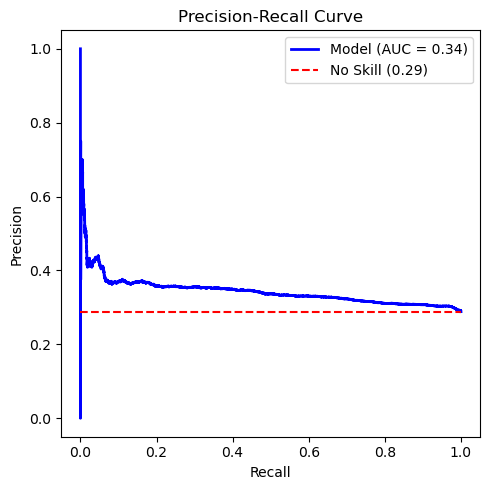

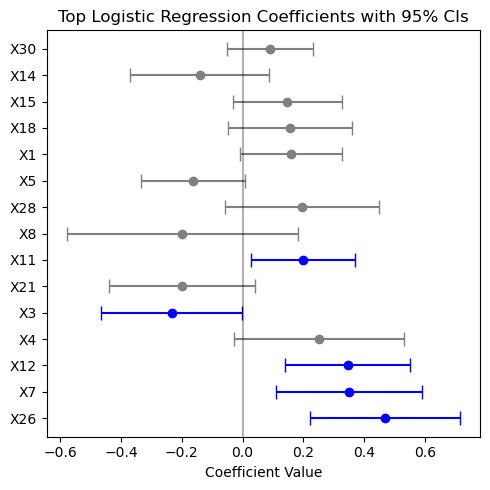

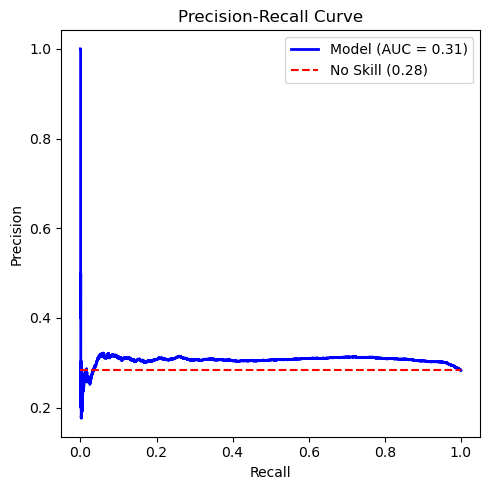

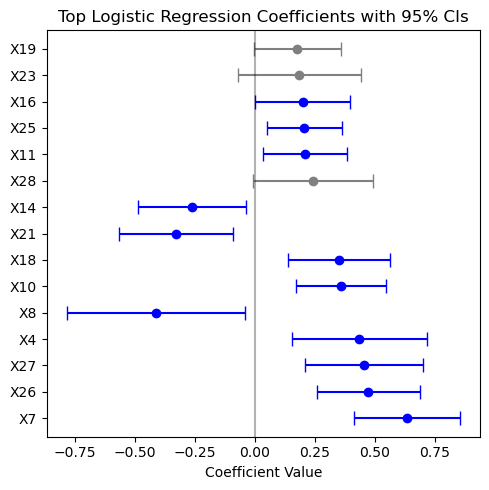

In [106]:
all_results_df['pr_auc_diff'] = all_results_df['pr_auc'] - all_results_df['pr_auc_baseline']

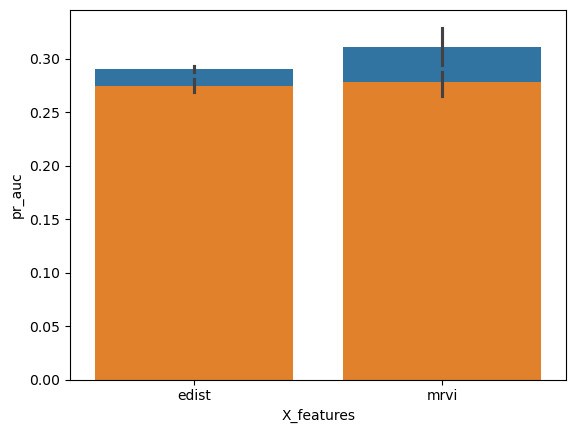

In [109]:
sns.barplot(
    data=all_results_df,
    x='X_features', y='pr_auc'
    );

sns.barplot(
    data=all_results_df,
    x='X_features', y='pr_auc_baseline'
    );
# plt.axhline(results_df['pr_auc_baseline'][0], color='grey', )

In [11]:
depmap_dependency = pd.read_table('./data_for_classifier/depmap_dependency_scores.tsv', index_col=0)
depmap_dependency['drug_organ'] = drug_cellline_df.set_index('drug-cell_line').loc[depmap_dependency.index]['drug_organ']
depmap_dependency.head()

,depmap_dependency_score,drug_organ
drug_cellline,,
(R)-Verapamil (hydrochloride)_CVCL_0031,0.039457,(R)-Verapamil (hydrochloride)_Breast
(R)-Verapamil (hydrochloride)_CVCL_1639,0.034305,(R)-Verapamil (hydrochloride)_Pancreas
(R)-Verapamil (hydrochloride)_CVCL_1125,0.038134,(R)-Verapamil (hydrochloride)_Peripheral Nervo...
(R)-Verapamil (hydrochloride)_CVCL_1119,0.070061,(R)-Verapamil (hydrochloride)_Pancreas
(R)-Verapamil (hydrochloride)_CVCL_1635,0.012977,(R)-Verapamil (hydrochloride)_Pancreas


In [12]:
input_features = edist_df
outcomes = depmap_dependency[['depmap_dependency_score', 'drug_organ']]

common_drug_organ = np.intersect1d(input_features['drug_organ'].unique(), outcomes['drug_organ'].unique())

input_features = input_features[input_features['drug_organ'].isin(common_drug_organ)]
input_features.head()

,max_e_distance,drug_organ
drug-cell_line,,
TAK-901_CVCL_1478,54.002503,TAK-901_Lung
TAK-901_CVCL_0218,54.002503,TAK-901_Bowel
TAK-901_CVCL_0428,54.002503,TAK-901_Pancreas
TAK-901_CVCL_0480,54.002503,TAK-901_Pancreas
TAK-901_CVCL_0320,54.002503,TAK-901_Bowel


In [13]:
drug_organ_vec = input_features['drug_organ']
outcomes = outcomes.set_index('drug_organ').loc[drug_organ_vec]
outcomes.index = input_features.index

# Convert indices to drug-cell_line
assert outcomes.shape[0] == input_features.shape[0]
X = input_features.drop('drug_organ', axis=1)
y = outcomes.copy()

ValueError: Length mismatch: Expected axis has 56784 elements, new values have 4459 elements

In [27]:
common_drug_organ = np.intersect1d(edist_df['drug_organ'].unique(), depmap_dependency['drug_organ'].unique())

In [30]:
common_drug_organ

array(['(R)-Verapamil (hydrochloride)_Bladder/Urinary Tract',
       '(R)-Verapamil (hydrochloride)_Bowel',
       '(R)-Verapamil (hydrochloride)_Breast', ...,
       'venetoclax_Peripheral Nervous System', 'venetoclax_Skin',
       'venetoclax_Uterus'], dtype=object)